# Classification

- Target = 0 if suicide rate <= national median
- Target = 1 if suicide rate > national median
- Features  = disease rates + state

Import libraries

In [2]:
import pandas as pd
import numpy as np

# DataPrep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn import metrics

import time
import glob
import shap
root = "../../"

# DataPrep
*You can skip this and load the csv directly after this section*

In [17]:
dict_uf_cod = {11: 'RO',
12: 'AC',
13: 'AM',
14: 'RR',
15: 'PA',
16: 'AP',
17: 'TO',
21: 'MA',
22: 'PI',
23: 'CE',
24: 'RN',
25: 'PB',
26: 'PE',
27: 'AL',
28: 'SE',
29: 'BA',
31: 'MG',
32: 'ES',
33: 'RJ',
35: 'SP',
41: 'PR',
42: 'SC',
43: 'RS',
50: 'MS',
51: 'MT',
52: 'GO',
53: 'DF'}

In [3]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

313  diseases


In [4]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-1):
    year_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_20" + years[i+1] + ".csv", index_col=0)
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,RISK
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,0


In [5]:
df = initial_df.copy()

In [6]:
# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)
df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
df.to_csv("df_classification_satscan.csv")

# Model

In [3]:
df = pd.read_csv("df_classification_satscan.csv",index_col=0)

Checking the number of 0s and 1s in TARGET column

In [4]:
unique, counts = np.unique(df["RISK"].values, return_counts=True)
dict(zip(unique, counts))

{0: 6032, 1: 3318}

Define X and y

In [5]:
X = df.drop(columns=["RISK"])
y = df["RISK"]

X.shape

(9350, 340)

Get scaled version of X

In [6]:
mm = MinMaxScaler()
sc = StandardScaler()
X_mm = mm.fit_transform(X)
X_sc = sc.fit_transform(X)

Define some functions

In [7]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature", how="right")
    final_feat_df = final_feat_df.fillna(0)
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df.sort_values(by="Avg_importance", ascending=False)

In [8]:
def sfm_feature_selector(X_train,y_train,max_features):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100),max_features=max_features)
    embeded_rf_selector.fit(X_train, y_train)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features (SFM)')
    return embeded_rf_feature

In [9]:
def get_average(scores_list):
    scores_avg_test = []
    for i in range(len(scores_list[0])):
        arr_list = [x[i] for x in scores_list]
        avg_result = np.array(arr_list).mean(axis=0)
        scores_avg_test.append(avg_result)
    return scores_avg_test

## 1. Random Forest Model

In [17]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: SFM")
    selected_sfm_features = sfm_feature_selector(X_train,y_train,num_feat)
    X_train = X_train[selected_sfm_features]
    X_test = X_test[selected_sfm_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    n_estimators = resultado_gp.x[0]
    max_depth = resultado_gp.x[1]
    min_samples_leaf = resultado_gp.x[2]
    max_features = resultado_gp.x[3]
    
    print("# Fitting the model")
    classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    classifier.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
    
    print("# Get Feature Importance")
    importance = classifier.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY ===============")
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4410  416]
 [1310 1344]]
              precision    recall  f1-score   support

           0      0.771     0.914     0.836      4826
           1      0.764     0.506     0.609      2654

    accuracy                          0.769      7480
   macro avg      0.767     0.710     0.723      7480
weighted avg      0.768     0.769     0.756      7480

Test
[[1100  106]
 [ 327  337]]
              precision    recall  f1-score   support

           0      0.771     0.912     0.836      1206
           1      0.761     0.508     0.609       664

    accuracy                          0.768      1870
   macro avg      0.766     0.710     0.722      1870
weighted avg      0.767     0.768     0.755      1870

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4381  445]
 [1298 1356]]
              precision    recall  f1-score   support

           0      0.771     0.908     0.834      4826
           1      0.753     0.511     0.609      2654

    accuracy                          0.767      7480
   macro avg      0.762     0.709     0.721      7480
weighted avg      0.765     0.767     0.754      7480

Test
[[1090  116]
 [ 332  332]]
              precision    recall  f1-score   support

           0      0.767     0.904     0.830      1206
           1      0.741     0.500     0.597       664

    accuracy                          0.760      1870
   macro avg      0.754     0.702     0.713      1870
weighted avg      0.757     0.760     0.747      1870

# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4159  

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4363  462]
 [1245 1410]]
              precision    recall  f1-score   support

           0      0.778     0.904     0.836      4825
           1      0.753     0.531     0.623      2655

    accuracy                          0.772      7480
   macro avg      0.766     0.718     0.730      7480
weighted avg      0.769     0.772     0.761      7480

Test
[[1097  110]
 [ 346  317]]
              precision    recall  f1-score   support

           0      0.760     0.909     0.828      1207
           1      0.742     0.478     0.582       663

    accuracy                          0.756      1870
   macro avg      0.751     0.693     0.705      1870
weighted avg      0.754     0.756     0.741      1870

# Get Feature Importance


=============== SUMMARY ===============
# Average Feature Importance
                                              Feature  Avg_importance
0                                                  R

## 2. LogisticRegression Model

### 2.1 Using MinMax Scaling

In [18]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_mm,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_mm[train_index], X_mm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("# Fitting the model")
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4413  413]
 [ 732 1922]]
              precision    recall  f1-score   support

           0      0.858     0.914     0.885      4826
           1      0.823     0.724     0.770      2654

    accuracy                          0.847      7480
   macro avg      0.840     0.819     0.828      7480
weighted avg      0.845     0.847     0.844      7480

Test
[[1082  124]
 [ 218  446]]
              precision    recall  f1-score   support

           0      0.832     0.897     0.864      1206
           1      0.782     0.672     0.723       664

    accuracy                          0.817      1870
   macro avg      0.807     0.784     0.793      1870
weighted avg      0.815     0.817     0.814      1870



=============== RUN 2 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4389  437]
 [ 731 1923]]
              precision    recall  f1-score 

### 2.2 Using StandardScaler

In [19]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_sc,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_sc[train_index], X_sc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("# Fitting the model")
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Fitting the model


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# Making predictions
# Calculating metrics
Train
[[4388  438]
 [ 638 2016]]
              precision    recall  f1-score   support

           0      0.873     0.909     0.891      4826
           1      0.822     0.760     0.789      2654

    accuracy                          0.856      7480
   macro avg      0.847     0.834     0.840      7480
weighted avg      0.855     0.856     0.855      7480

Test
[[1068  138]
 [ 195  469]]
              precision    recall  f1-score   support

           0      0.846     0.886     0.865      1206
           1      0.773     0.706     0.738       664

    accuracy                          0.822      1870
   macro avg      0.809     0.796     0.802      1870
weighted avg      0.820     0.822     0.820      1870



=============== RUN 2 ===============
# Fitting the model


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# Making predictions
# Calculating metrics
Train
[[4372  454]
 [ 667 1987]]
              precision    recall  f1-score   support

           0      0.868     0.906     0.886      4826
           1      0.814     0.749     0.780      2654

    accuracy                          0.850      7480
   macro avg      0.841     0.827     0.833      7480
weighted avg      0.849     0.850     0.849      7480

Test
[[1069  137]
 [ 168  496]]
              precision    recall  f1-score   support

           0      0.864     0.886     0.875      1206
           1      0.784     0.747     0.765       664

    accuracy                          0.837      1870
   macro avg      0.824     0.817     0.820      1870
weighted avg      0.836     0.837     0.836      1870



=============== RUN 3 ===============
# Fitting the model


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# Making predictions
# Calculating metrics
Train
[[4378  448]
 [ 642 2012]]
              precision    recall  f1-score   support

           0      0.872     0.907     0.889      4826
           1      0.818     0.758     0.787      2654

    accuracy                          0.854      7480
   macro avg      0.845     0.833     0.838      7480
weighted avg      0.853     0.854     0.853      7480

Test
[[1046  160]
 [ 185  479]]
              precision    recall  f1-score   support

           0      0.850     0.867     0.858      1206
           1      0.750     0.721     0.735       664

    accuracy                          0.816      1870
   macro avg      0.800     0.794     0.797      1870
weighted avg      0.814     0.816     0.815      1870



=============== RUN 4 ===============
# Fitting the model


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# Making predictions
# Calculating metrics
Train
[[4381  444]
 [ 640 2015]]
              precision    recall  f1-score   support

           0      0.873     0.908     0.890      4825
           1      0.819     0.759     0.788      2655

    accuracy                          0.855      7480
   macro avg      0.846     0.833     0.839      7480
weighted avg      0.854     0.855     0.854      7480

Test
[[1071  136]
 [ 201  462]]
              precision    recall  f1-score   support

           0      0.842     0.887     0.864      1207
           1      0.773     0.697     0.733       663

    accuracy                          0.820      1870
   macro avg      0.807     0.792     0.798      1870
weighted avg      0.817     0.820     0.818      1870



=============== RUN 5 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4369  456]
 [ 637 2018]]
              precision    recall  f1-score   support

           0      0.873     0.905     0.889    

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## 3. SVM
### 3.1 LinearSVC

In [20]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_mm,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_mm[train_index], X_mm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("# Fitting the model")
    classifier = LinearSVC()
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4408  418]
 [ 676 1978]]
              precision    recall  f1-score   support

           0      0.867     0.913     0.890      4826
           1      0.826     0.745     0.783      2654

    accuracy                          0.854      7480
   macro avg      0.846     0.829     0.836      7480
weighted avg      0.852     0.854     0.852      7480

Test
[[1074  132]
 [ 199  465]]
              precision    recall  f1-score   support

           0      0.844     0.891     0.866      1206
           1      0.779     0.700     0.738       664

    accuracy                          0.823      1870
   macro avg      0.811     0.795     0.802      1870
weighted avg      0.821     0.823     0.821      1870



=============== RUN 2 ===============
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4398  428]
 [ 689 1965]]
              precision    recall  f1-score 

### 3.2 SVC (RBF Kernel)

In [21]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X_mm,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X_mm[train_index], X_mm[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4518  308]
 [ 727 1927]]
              precision    recall  f1-score   support

           0      0.861     0.936     0.897      4826
           1      0.862     0.726     0.788      2654

    accuracy                          0.862      7480
   macro avg      0.862     0.831     0.843      7480
weighted avg      0.862     0.862     0.859      7480

Test
[[1097  109]
 [ 233  431]]
              precision    recall  f1-score   support

           0      0.825     0.910     0.865      1206
           1      0.798     0.649     0.716       664

    accuracy                          0.817      1870
   macro avg      0.811     0.779     0.791      1870
weighted avg      0.815     0.817     0.812      1870



=============== RUN 2 ===============
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[4450  376]
 [ 700 195

In [22]:
from mixed_naive_bayes import MixedNB

start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier = MixedNB(categorical_features=[X.columns.get_loc(col) for col in list(dict_uf_cod.values())])
    classifier.fit(X,y)
    classifier.predict(X)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3))
    scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                  "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                  "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train),
                  "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred)}, ignore_index=True)
  
    print("\n")
    count += 1
print("=============== SUMMARY ===============")

print("# Average Metrics")
print("## Train")
avg_accuracy_train = scores["accuracy_train"].mean()
avg_score_train = get_average(scores["scores_train"])
print("accuracy_train:", avg_accuracy_train)
print("precision_train:", avg_score_train[0].mean())
print("recall_train:", avg_score_train[1].mean())
print("f1_score_train:", avg_score_train[2].mean())
print("## Test")
avg_accuracy_test = scores["accuracy_test"].mean()
avg_score_test = get_average(scores["scores_test"])
print("accuracy_test:", avg_accuracy_test)
print("precision_test:", avg_score_test[0].mean())
print("recall_test:", avg_score_test[1].mean())
print("f1_score_test:", avg_score_test[2].mean())

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[4826    0]
 [2654    0]]
              precision    recall  f1-score   support

           0      0.645     1.000     0.784      4826
           1      0.000     0.000     0.000      2654

    accuracy                          0.645      7480
   macro avg      0.323     0.500     0.392      7480
weighted avg      0.416     0.645     0.506      7480

Test
[[1206    0]
 [ 664    0]]
              precision    recall  f1-score   support

           0      0.645     1.000     0.784      1206
           1      0.000     0.000     0.000       664

    accuracy                          0.645      1870
   macro avg      0.322     0.500     0.392      1870
weighted avg      0.416     0.645     0.506      1870



=============== RUN 2 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Making predictions
# Calculating metrics
Train
[[4826    0]
 [2654    0]]
              precision    recall  f1-score   support

           0      0.645     1.000     0.784      4826
           1      0.000     0.000     0.000      2654

    accuracy                          0.645      7480
   macro avg      0.323     0.500     0.392      7480
weighted avg      0.416     0.645     0.506      7480

Test
[[1206    0]
 [ 664    0]]
              precision    recall  f1-score   support

           0      0.645     1.000     0.784      1206
           1      0.000     0.000     0.000       664

    accuracy                          0.645      1870
   macro avg      0.322     0.500     0.392      1870
weighted avg      0.416     0.645     0.506      1870



=============== RUN 3 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[4826    0]
 [2654    0]]
              precision    recall  f1-score   support

           

# Previsões 2018

In [13]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

313  diseases


In [14]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    year_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_20" + years[i+1] + ".csv", index_col=0)
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N)
    train_df = pd.concat([train_df, year_df])

train_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,RISK
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,0


In [18]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)
train_df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [61]:
percentage_valid_values = 0.8
test_df = pd.read_csv(root + "CSV/SatScan/MuncodRisk/cluster_risk_2018.csv", index_col=0)
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df[disease] = disease_df[col_year_disease] 
    disease_df = disease_df.drop(columns={col_year_disease})
    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(test_df.shape[1]*percentage_valid_values)
test_df = test_df.dropna(thresh=N)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,RISK
0,110001,19.656406,23.587687,19.656406,231.945591,NaN,NaN,NaN,11.793844,NaN,...,0.000000,NaN,0.000000,NaN,55.037937,70.763062,3.931281,NaN,19.656406,0
1,110002,8.384182,13.973636,1.863152,32.605152,NaN,0.000000,NaN,1.863152,0.000000,...,0.931576,NaN,29.810424,0.0,13.042061,71.731334,3.726303,0.0,39.126182,0
3,110004,9.038833,20.337374,3.389562,42.934457,NaN,NaN,NaN,0.000000,2.259708,...,0.000000,NaN,NaN,0.0,11.298541,73.440519,1.129854,0.0,5.649271,0
8,110009,3.027551,12.110203,3.027551,6.055101,NaN,NaN,NaN,0.000000,NaN,...,9.082652,NaN,0.000000,NaN,9.082652,45.413261,39.358159,0.0,15.137754,0
9,110010,2.107437,0.000000,2.107437,14.752060,NaN,2.107437,0.0,2.107437,0.000000,...,21.074371,0.0,2.107437,NaN,21.074371,18.966934,0.000000,0.0,219.173463,0


In [62]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['UF'], axis=1)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,110001,19.656406,23.587687,19.656406,231.945591,0.0,0.000000,0.0,11.793844,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,110002,8.384182,13.973636,1.863152,32.605152,0.0,0.000000,0.0,1.863152,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,110004,9.038833,20.337374,3.389562,42.934457,0.0,0.000000,0.0,0.000000,2.259708,...,0,0,0,1,0,0,0,0,0,0
8,110009,3.027551,12.110203,3.027551,6.055101,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
9,110010,2.107437,0.000000,2.107437,14.752060,0.0,2.107437,0.0,2.107437,0.000000,...,0,0,0,1,0,0,0,0,0,0


In [63]:
X_train = train_df.drop(columns=["RISK"])
y_train = train_df["RISK"]
X_test = test_df.drop(columns=["RISK", "MUNCOD"])
y_test = test_df["RISK"]

In [64]:
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [65]:
print("# Bayesian Optimization")
def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("# Fitting the model")
classifier = SVC(random_state=42,C=C,probability=True)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
print("Train")
print(metrics.confusion_matrix(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train, digits=3))
print("Test")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))

# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[5167  318]
 [ 809 2121]]
              precision    recall  f1-score   support

           0      0.865     0.942     0.902      5485
           1      0.870     0.724     0.790      2930

    accuracy                          0.866      8415
   macro avg      0.867     0.833     0.846      8415
weighted avg      0.866     0.866     0.863      8415

Test
[[520  27]
 [189 199]]
              precision    recall  f1-score   support

           0      0.733     0.951     0.828       547
           1      0.881     0.513     0.648       388

    accuracy                          0.769       935
   macro avg      0.807     0.732     0.738       935
weighted avg      0.794     0.769     0.753       935



In [66]:
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoplot
import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

In [67]:
gd = gpd.read_file(root + "Maps/BRMUE250GC_SIR.shp")

In [68]:
mun_risk_ids_pred = test_df[y_pred == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true = test_df[y_test == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids = [x for x in mun_risk_ids_pred if x in mun_risk_ids_true]
mun_risk_ids_not = [x for x in mun_risk_ids_pred if x not in mun_risk_ids_true]
mun_risk_ids_not_2 = [x for x in mun_risk_ids_true if x not in mun_risk_ids_pred]

In [69]:
def remove_last_digit(x):
    return np.floor(x.astype(int) / 10).astype(int)

(-76.24759047174993,
 -26.590499411249954,
 -35.70232894754993,
 7.222992030550032)

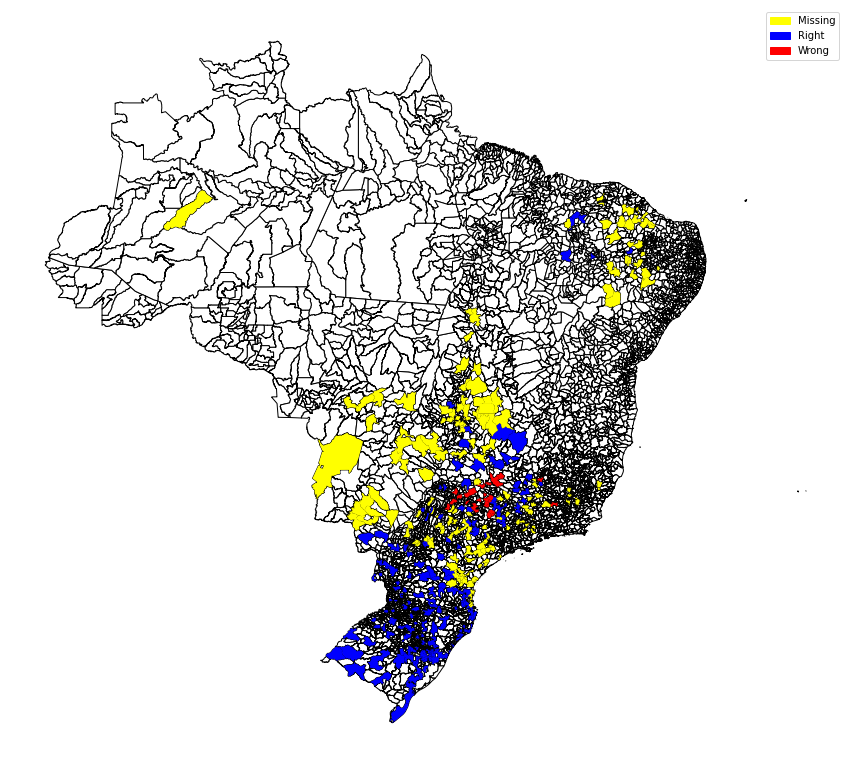

In [70]:
fig, ax = plt.subplots(figsize=(15,15))
gd.plot(ax=ax, color="white", edgecolor='black')
gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
plot_risk = gd_risk.plot(ax=ax, color="blue")

gd_risk_not = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_not)]
plot_risk_not = gd_risk_not.plot(ax=ax, color="red")

gd_risk_not_2 = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_not_2)]
plot_risk_not_2 = gd_risk_not_2.plot(ax=ax, color="yellow")

red_patch = mpatches.Patch(color='blue', label='Right')
blue_patch = mpatches.Patch(color='red', label='Wrong')
yellow_patch = mpatches.Patch(color='yellow', label='Missing')
plt.legend(handles=[yellow_patch,red_patch,blue_patch])
plt.axis('off')

# SHAP

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.3, stratify=y)
num_feat = 30

print("# Feature Selection: SFM")
selected_sfm_features = sfm_feature_selector(X_train,y_train,num_feat)
X_train = X_train[selected_sfm_features]
X_test = X_test[selected_sfm_features]

print("# Bayesian Optimization")
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]

print("# Fitting the model")
classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
print("Train")
print(metrics.confusion_matrix(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train, digits=3))
print("Test")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))

print("# Get Feature Importance")
importance = classifier.feature_importances_
print(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))

# Feature Selection: SFM
30 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[3926  296]
 [1201 1122]]
              precision    recall  f1-score   support

           0      0.766     0.930     0.840      4222
           1      0.791     0.483     0.600      2323

    accuracy                          0.771      6545
   macro avg      0.779     0.706     0.720      6545
weighted avg      0.775     0.771     0.755      6545

Test
[[1676  134]
 [ 534  461]]
              precision    recall  f1-score   support

           0      0.758     0.926     0.834      1810
           1      0.775     0.463     0.580       995

    accuracy                          0.762      2805
   macro avg      0.767     0.695     0.707      2805
weighted avg      0.764     0.762     0.744      2805

# Get Feature Importance
                                              Feature  Importance
28                                                 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


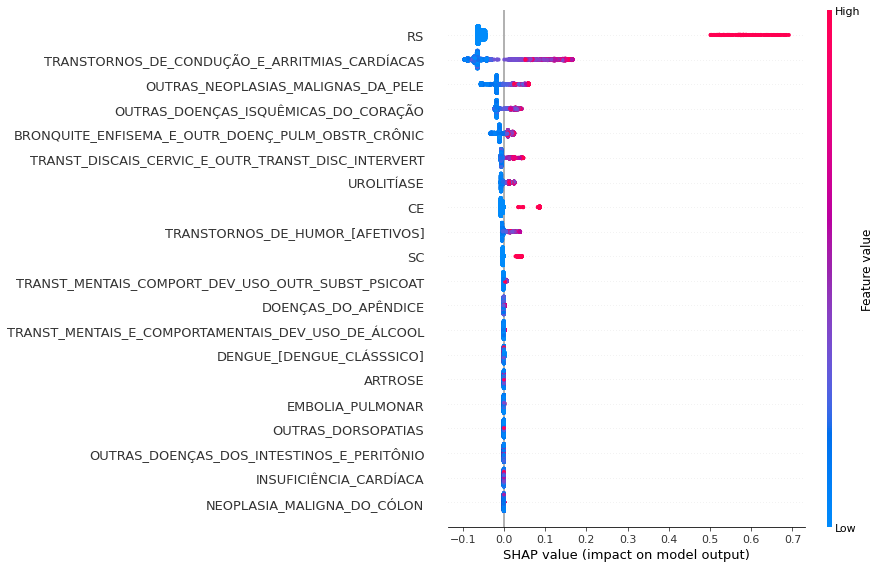

In [73]:
explainer = shap.TreeExplainer(classifier)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)

## SHAP individual analysis 

In [80]:
test_df.loc[test_df['MUNCOD'] == 355030]["RISK"]

3624    0
Name: RISK, dtype: int64

In [77]:
data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "RISK"])

data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [78]:
explainer = shap.TreeExplainer(classifier)

shap_values = explainer.shap_values(data_for_prediction)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [79]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.3, stratify=y)
num_feat = 30

print("# Fitting the model")
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
print("Train")
print(metrics.confusion_matrix(y_train, y_pred_train))
print(metrics.classification_report(y_train, y_pred_train, digits=3))
print("Test")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[3796  426]
 [ 708 1615]]
              precision    recall  f1-score   support

           0      0.843     0.899     0.870      4222
           1      0.791     0.695     0.740      2323

    accuracy                          0.827      6545
   macro avg      0.817     0.797     0.805      6545
weighted avg      0.825     0.827     0.824      6545

Test
[[1603  207]
 [ 336  659]]
              precision    recall  f1-score   support

           0      0.827     0.886     0.855      1810
           1      0.761     0.662     0.708       995

    accuracy                          0.806      2805
   macro avg      0.794     0.774     0.782      2805
weighted avg      0.803     0.806     0.803      2805



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [85]:
explainer = shap.LinearExplainer(classifier, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)

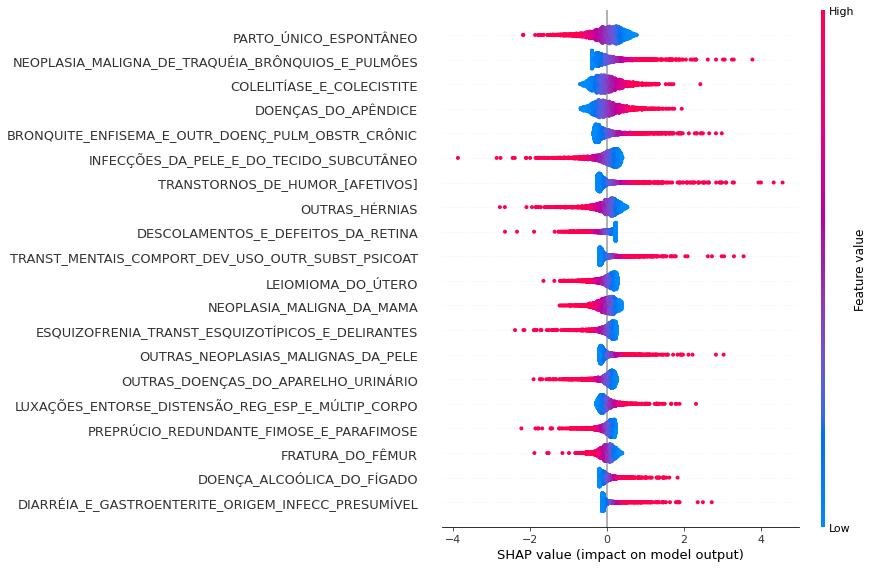

In [91]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)